In [ ]:
!pip install pulp --quiet

# **IMPORTING LIBRARIES**

In [ ]:
import pandas as pd
import pulp as pu
import matplotlib.pyplot as plt
from itertools import chain, repeat

# **DECLARING A HELPER FUNCTION** 

In [ ]:
def ncycles(iterable, n):
    "Returns the sequence elements n times"
    return chain.from_iterable(repeat(tuple(iterable), n))

# **PLOT SCENARIO DATA**

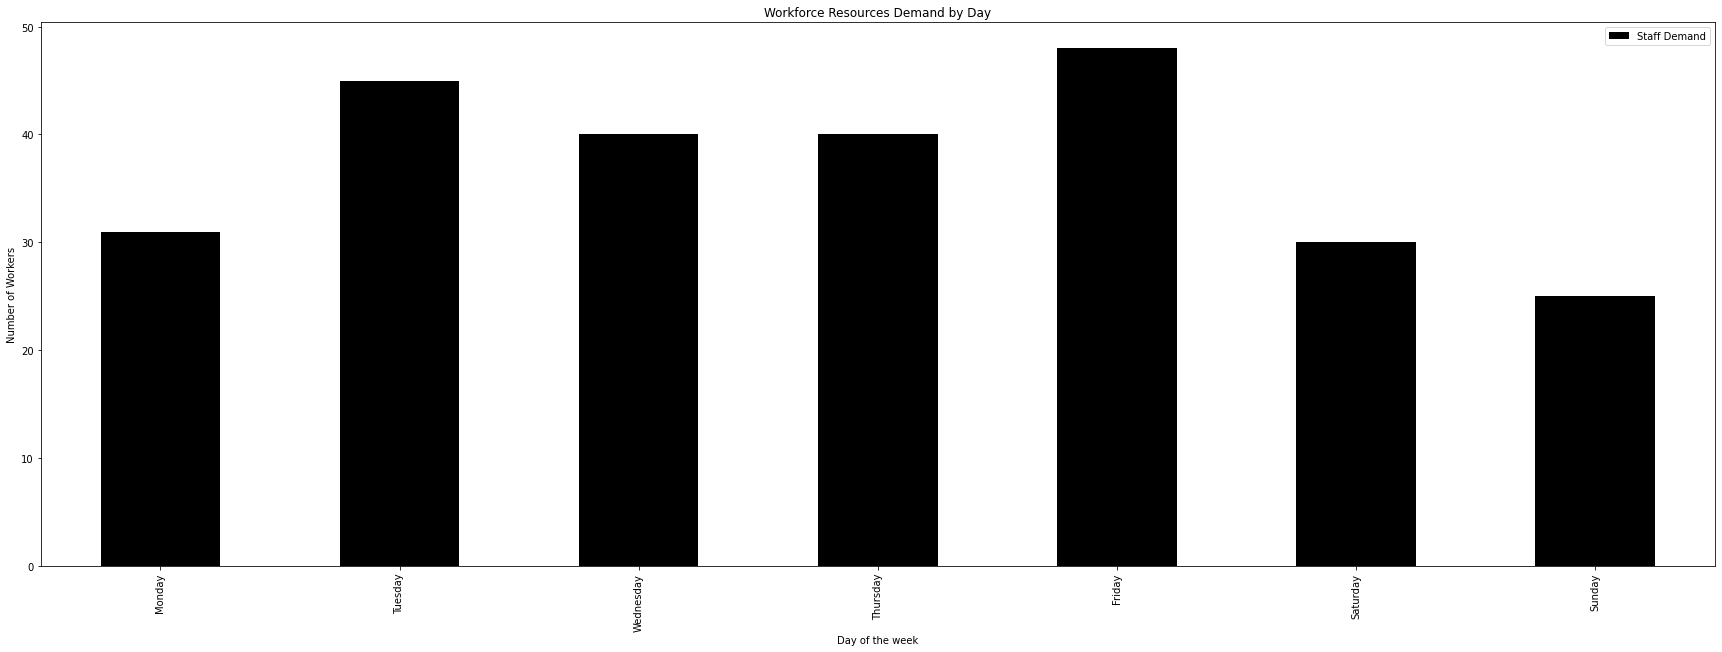

In [ ]:
# Staff needed per Day (FTE)
n_staff = [31, 45, 40, 40, 48, 30, 25]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Staff
df_staff = pd.DataFrame({'Days': days, 'Staff Demand':n_staff})
df_staff[['Days', 'Staff Demand']].plot.bar(x='Days', figsize = (30, 10), fill=True, color='black')
plt.title('Workforce Resources Demand by Day')
plt.xlabel('Day of the week')
plt.ylabel('Number of Workers')
plt.show()

# **OPTIMIZATION: MINIMIZING THE STAFF**

**Preparing circular lists and workdays**

In [ ]:
# Create circular list of days
n_days = [i for i in range(7)]
n_days_c = list(ncycles(n_days, 3)) 

# Working days
list_in = [[n_days_c[j] for j in range(i , i + 5)] for i in n_days_c]

# Days off
list_excl = [[n_days_c[j] for j in range(i + 1, i + 3)] for i in n_days_c]

**Building the model, adding constraints, setting objective and then solving**

In [ ]:
# The class has been initialized, and x, and days are defined
model = pu.LpProblem("Minimize Staffing", pu.LpMinimize)

# Create Variables
start_days = ['Shift: ' + i for i in days]
x = pu.LpVariable.dicts('shift_', n_days, lowBound=0, cat='Integer')

# Define Objective
model += pu.lpSum([x[i] for i in n_days])

# Add constraints
for d, l_excl, staff in zip(n_days, list_excl, n_staff):
    model += pu.lpSum([x[i] for i in n_days if i not in l_excl]) >= staff

# Solve Model
model.solve()

# The status of the solution is printed to the screen
print("Status:", pu.LpStatus[model.status])

Status: Optimal


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


**Solution**

In [ ]:
# How many workers per day ?
dct_work = {}
dico_work = {}
for v in model.variables():
    dct_work[int(v.name[-1])] = int(v.varValue)
    dico_work[v.name] = int(v.varValue)
dico_work

{'shift__0': 14,
 'shift__1': 14,
 'shift__2': 8,
 'shift__3': 0,
 'shift__4': 13,
 'shift__5': 0,
 'shift__6': 4}

**Total number of FTE**

In [ ]:
# Show workers schedule
dict_sch = {}
for day in dct_work.keys():
    dict_sch[day] = [dct_work[day] if i in list_in[day] else 0 for i in n_days]
df_sch = pd.DataFrame(dict_sch).T
df_sch.columns = days
df_sch.index = start_days
# The optimized objective function value is printed to the screen
print("Total number of Staff = ", pu.value(model.objective))

Total number of Staff =  53.0


**Shift-wise presentation**

In [ ]:
# Detailed
df_sch

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Shift: Monday,14,14,14,14,14,0,0
Shift: Tuesday,0,14,14,14,14,14,0
Shift: Wednesday,0,0,8,8,8,8,8
Shift: Thursday,0,0,0,0,0,0,0
Shift: Friday,13,13,0,0,13,13,13
Shift: Saturday,0,0,0,0,0,0,0
Shift: Sunday,4,4,4,4,0,0,4


In [ ]:
# Sum by day
df_sch.sum(axis = 0)

Monday       31
Tuesday      45
Wednesday    40
Thursday     40
Friday       49
Saturday     35
Sunday       25
dtype: int64

In [ ]:
df_supp = df_staff.copy().set_index('Days')
df_supp['Staff Supply'] = df_sch.sum(axis = 0)
df_supp['Extra_Resources'] = df_supp['Staff Supply'] - df_supp['Staff Demand']
df_supp.to_csv('test.csv')

# **Visualizing Workforce Supply vs Demand**

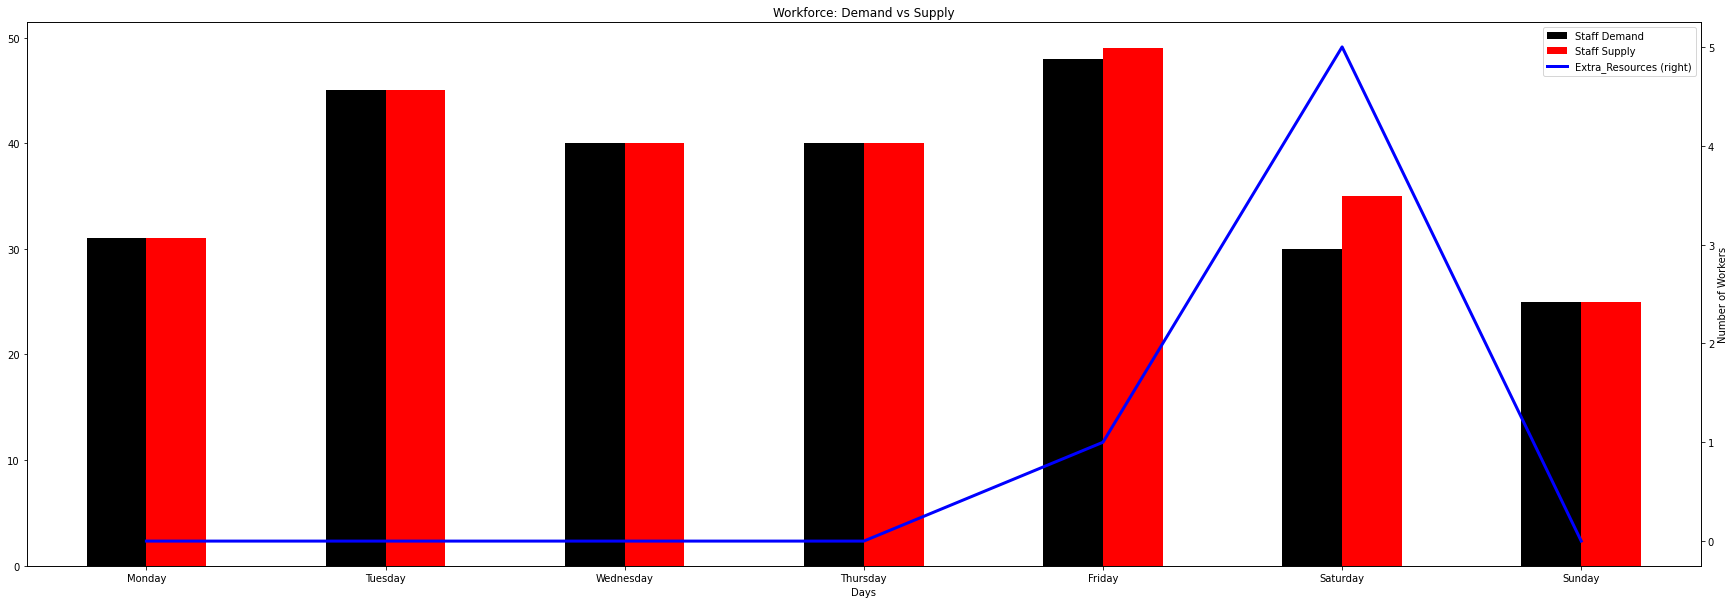

In [ ]:
# Staff
ax = df_supp.plot.bar(y=['Staff Demand', 'Staff Supply'], figsize = (30, 10), fill=True, color=['black', 'red'])
df_supp.plot(y=['Extra_Resources'], color=['blue'], secondary_y = True, ax = ax, linewidth = 3)
plt.title('Workforce: Demand vs Supply')
plt.xlabel('Day of the week')
plt.ylabel('Number of Workers')
plt.show()